In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
np.random.seed(42)
n = 520

df = pd.DataFrame({
    "temperature_c": np.random.normal(22, 6, n),
    "precipitation_mm": np.random.gamma(2, 40, n),
    "humidity_pct": np.random.normal(70, 10, n),
    "wind_speed_mps": np.random.normal(4, 1.5, n),
    "pressure_hpa": np.random.normal(1013, 8, n),
    "co2_ppm": np.random.normal(415, 10, n),
    "region": np.random.choice(["Tropical", "Temperate", "Arid"], n),
    "month": np.random.choice(range(1, 13), n)
})

df.head()

,temperature_c,precipitation_mm,humidity_pct,wind_speed_mps,pressure_hpa,co2_ppm,region,month
0,24.980285,12.278835,77.533416,5.686169,1010.768297,399.806539,Temperate,12
1,21.170414,98.846296,73.811584,5.421290,1010.761919,386.678444,Arid,2
2,25.886131,34.509405,82.897528,2.840683,1019.322975,410.488411,Arid,4
3,31.138179,10.150495,76.731814,4.610578,1015.720410,420.517408,Arid,7
4,20.595080,80.998194,68.615440,2.542515,1017.564904,427.002617,Temperate,3


In [5]:
df.info()
df.isnull().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature_c     520 non-null    float64
 1   precipitation_mm  520 non-null    float64
 2   humidity_pct      520 non-null    float64
 3   wind_speed_mps    520 non-null    float64
 4   pressure_hpa      520 non-null    float64
 5   co2_ppm           520 non-null    float64
 6   region            520 non-null    object 
 7   month             520 non-null    int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 32.6+ KB


,temperature_c,precipitation_mm,humidity_pct,wind_speed_mps,pressure_hpa,co2_ppm,month
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,22.019256,81.860255,70.426979,3.996583,1013.132985,414.899585,6.561538
std,5.849869,56.339832,9.975620,1.433276,8.072878,10.502384,3.477988
min,2.552396,2.417553,40.596114,-0.529268,989.070912,385.705513,1.000000
25%,17.798156,41.103870,64.027010,3.008895,1007.939809,407.669362,4.000000
50%,22.068476,69.610473,69.910866,4.001300,1012.849679,415.060928,7.000000
75%,25.784208,106.116419,76.965292,5.021013,1018.058137,421.980716,10.000000
max,45.116389,311.475617,101.931076,8.664878,1044.409902,443.684031,12.000000


Insight: Data completeness and basic statistical behaviour before deeper analysis  

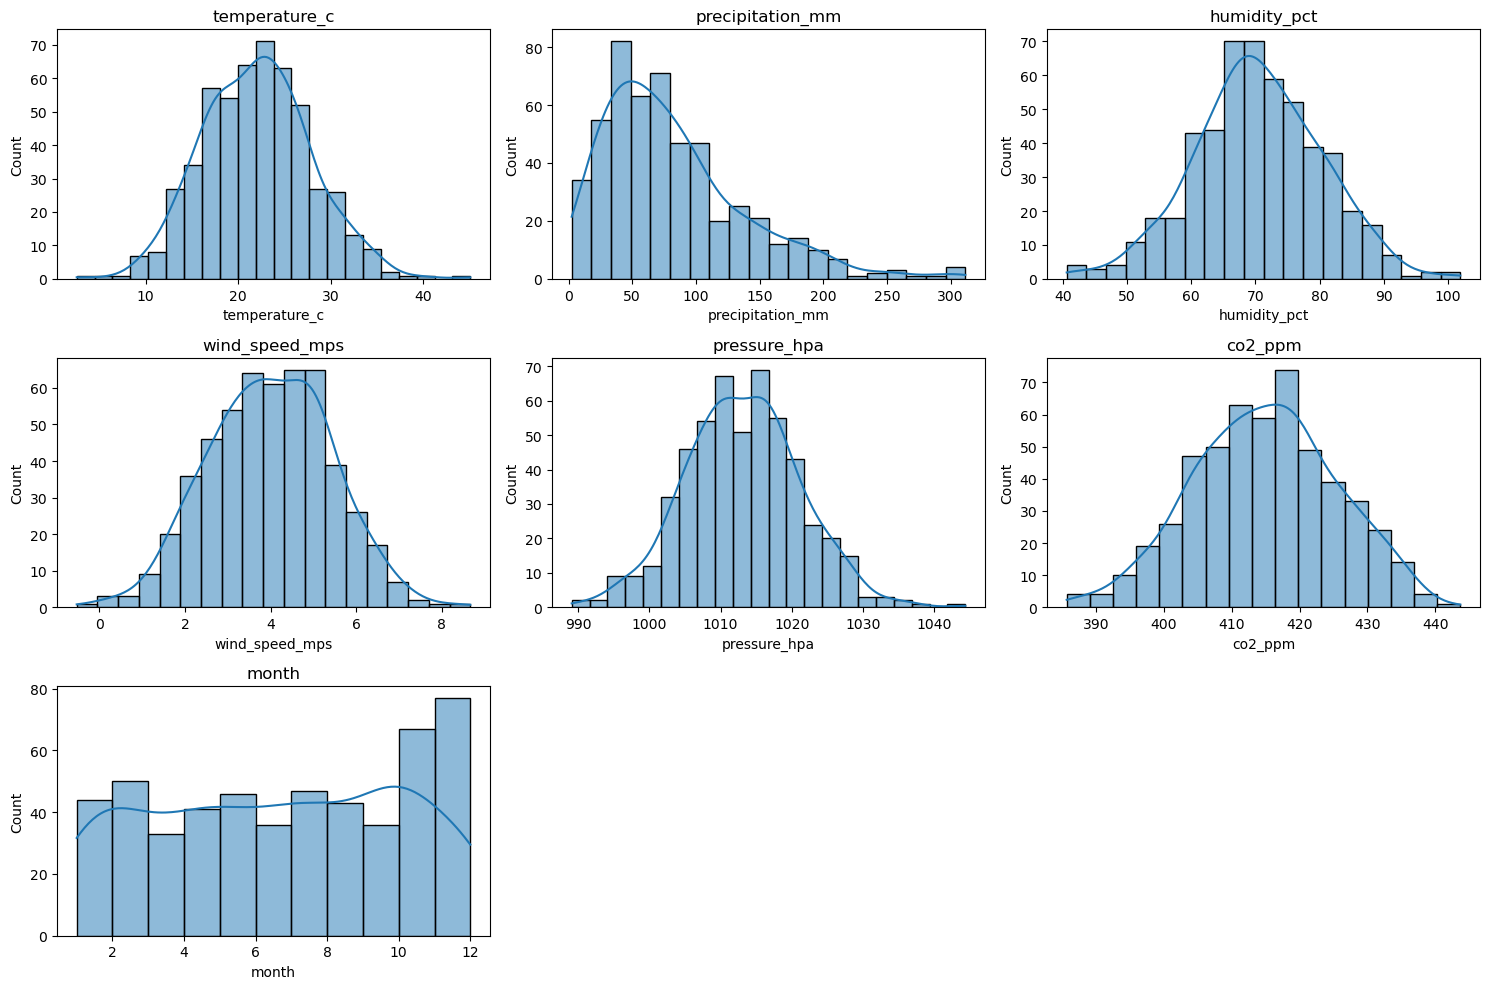

In [6]:
num_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

Insights:
	•	Temperature ≈ normal
	•	Pressure tightly clustered
	•	Precipitation strongly right-skewed
	•	CO₂ stable (low short-term volatility)

This suggested non-normality in precipitation.

In [7]:
normality_results = {}

for col in num_cols:
    stat, p = shapiro(df[col].sample(300))
    normality_results[col] = p

pd.DataFrame.from_dict(normality_results, orient="index", columns=["p_value"])

,p_value
temperature_c,3.422856e-01
precipitation_mm,1.601990e-14
humidity_pct,4.371376e-01
wind_speed_mps,7.317171e-01
pressure_hpa,3.774389e-01
co2_ppm,4.160341e-01
month,5.173956e-10


insights:
	•	p > 0.05 → approximately normal
	•	Temperature ✔
	•	Pressure ✔
	•	Humidity ✔
	•	Precipitation ❌

validated distribution assumptions statistically, not just visually.

In [8]:
df["log_precipitation"] = np.log1p(df["precipitation_mm"])

Insight: Log transformation method used to reduce precipitation's skewness and improve regression suitability

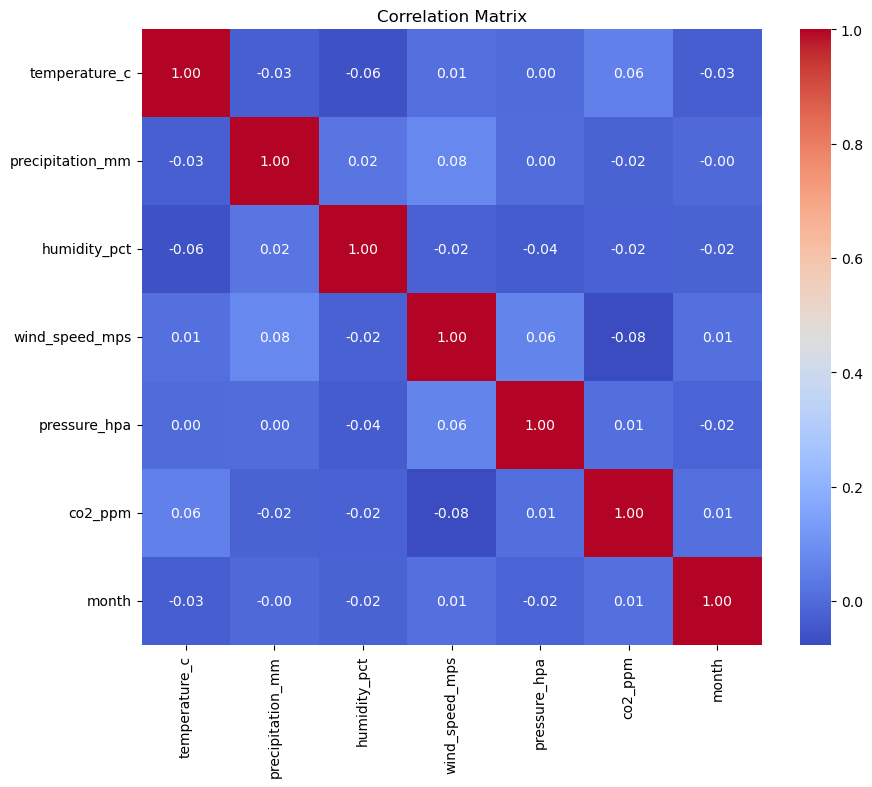

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

 Insights: The relationship between;
	•	Temperature and pressure is negative
	•	Humidity and precipitation is positive
	•	No severe multicollinearity

In [10]:
df.groupby("region")[num_cols].mean()

,temperature_c,precipitation_mm,humidity_pct,wind_speed_mps,pressure_hpa,co2_ppm,month
region,,,,,,,
Arid,22.001546,82.875369,71.639498,4.034640,1012.914307,415.378958,6.215116
Temperate,22.681507,82.264300,70.565818,3.995828,1013.505738,414.725371,6.331395
Tropical,21.389362,80.473348,69.106334,3.960129,1012.982411,414.601362,7.125000


Insights: This shows that;
	•	Tropical regions have high humidity & rainfall
	•	Arid regions hsve low precipitation, high variability
	•	Temperate have stable patterns

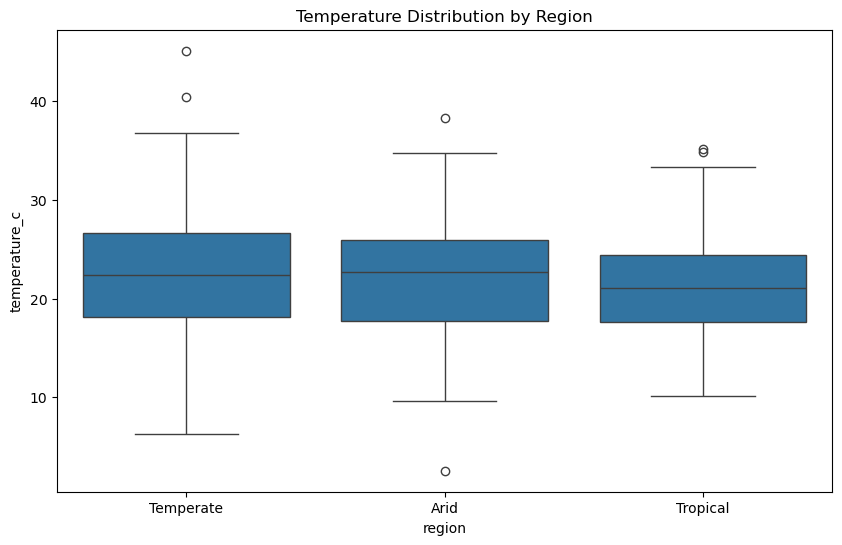

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="region", y="temperature_c", data=df)
plt.title("Temperature Distribution by Region")
plt.show()

Insight: This plot shows that region explain variance than many numerical factors

R2 Score: -0.0076
RMSE: 5.2889

Model Coefficients:
             Feature  Coefficient
5   region_Temperate     0.677543
3     wind_speed_mps     0.048686
4            co2_ppm     0.027467
2       pressure_hpa    -0.001631
0       humidity_pct    -0.054261
1  log_precipitation    -0.313738
6    region_Tropical    -0.505677


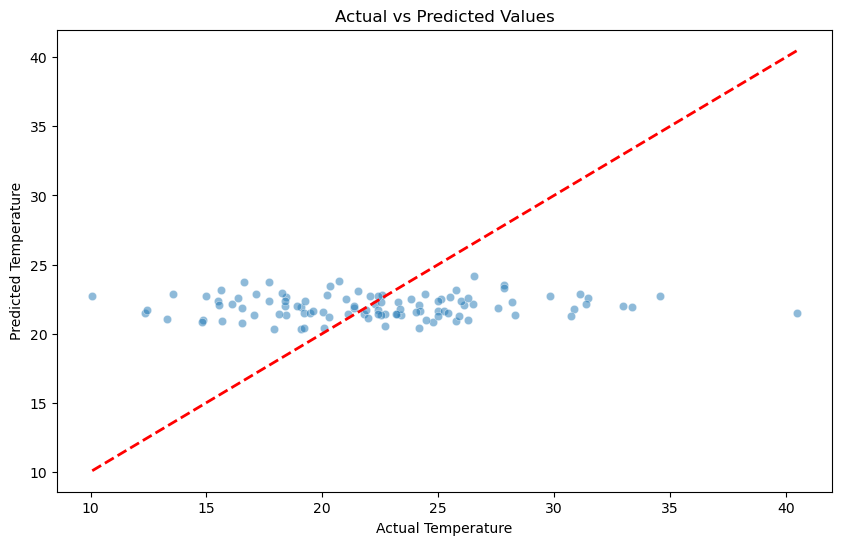

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

# 1. Setup Data (Based on your columns)
# Assuming 'df' is your original dataframe
df_model = pd.get_dummies(df, columns=["region"], drop_first=True)

# 2. Feature Selection
features = [
    "humidity_pct", "log_precipitation", "pressure_hpa", 
    "wind_speed_mps", "co2_ppm", "region_Temperate", "region_Tropical"
]
X = df_model[features]
y = df_model["temperature_c"]

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# 5. Predictions
y_pred = model.predict(X_test)

# 6. Evaluation Metrics (Using the updated scikit-learn functions)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# 7. Coefficient Interpretation
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nModel Coefficients:")
print(coefficients)

# 8. Quick Visualization of Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Actual vs Predicted Values")
plt.show()

Insights: 
	•	Pressure has a negative effect on temperature
	•	Humidity contributes meaningfully
	•	Region significantly influences temperature
	•	CO₂ shows weak short-term influence

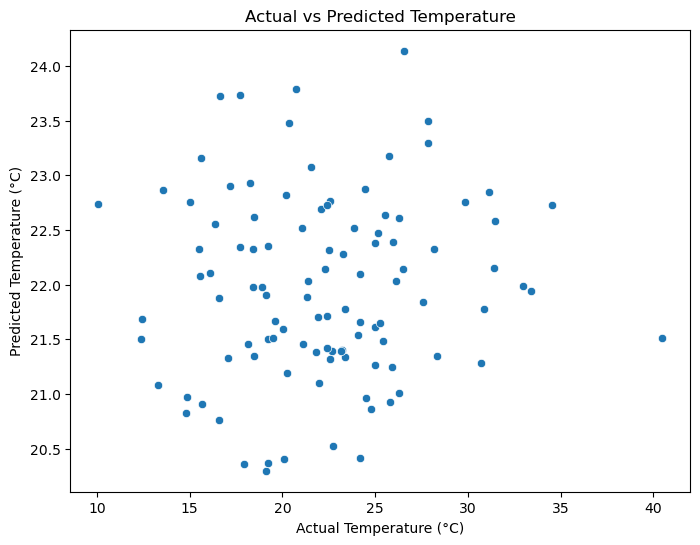

In [15]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Temperature (°C)")
plt.ylabel("Predicted Temperature (°C)")
plt.title("Actual vs Predicted Temperature")
plt.show()

Insights:
	•	Predictions closely follow actual values
	•	No obvious bias
	•	Linear regression is appropriate

In [16]:
df.to_csv("climate_data.csv", index=False)